In [97]:
import mesa
import numpy as np
import mesa.time as mt
import mesa.space as ms
import mesa.batchrunner as mb
import matplotlib.pyplot as plt
import rasterio
from PIL import Image


In [98]:
# Read the tif file with DEM data
dem_file = "data/UK_DEM.tif"
dem_image = Image.open(dem_file)

# store the dem data into array
dem_array = np.array(dem_image)

In [99]:
# Obtain geographic resolution information
with rasterio.open(dem_file) as src:
    x_resolution = src.transform[0]
    y_resolution = src.transform[4]
    # The average of the x and y directions is taken as the geographic resolution of the pixel
    pixel_resolution = (abs(x_resolution) + abs(y_resolution)) / 2.0
    print("Each pixel of the DEM equals [" + str(pixel_resolution) + "m] in the real world")

Each pixel of the DEM equals [10.0m] in the real world


In [100]:
class Patch:
    def __init__(self, pos, model, pixel_resolution):
        self.pos = pos
        self.model = model
        self.elevation = None  # elevation value of each patch
        self.state = False # fire or note
        self.start = False #  whether it is the point of origin of the fire
        self.side_length = pixel_resolution # the side length of each patch

    # Definition of an agent's behavior
    def burn(self):
        print("Sorry, I am on fire! :(")


In [107]:
# defined the abm world
class ABMWorld(ms.SingleGrid):
    def __init__(self, dem_array, pixel_resolution):
        self.height = dem_array.shape[0]
        self.width = dem_array.shape[1]
        self.pixel_resolution = pixel_resolution
        super().__init__(self.width, self.height, False)
        
        # set the elevation
        for x in range(self.width):
            for y in range(self.height):
                elevation = dem_array[y, x]
                patch = Patch((x, y), self, pixel_resolution)
                patch.elevation = elevation
                self.place_agent(patch, (x, y))


In [115]:
# Create the abm model
class ABMModel(mt.Model):
    def __init__(self, dem_array, pixel_resolution):
        self.schedule = mt.RandomActivation(self)
        self.grid = ABMWorld(dem_array, pixel_resolution)

    def spread_fire(self, x, y):
        fire_patch = self.grid[x][y]
        fire_patch.start = True

        # 获取邻域8个位置的坐标
        neighbors = [(x-1, y-1), (x, y-1), (x+1, y-1),
                     (x-1, y), (x+1, y),
                     (x-1, y+1), (x, y+1), (x+1, y+1)]

        for neighbor_x, neighbor_y in neighbors:
            # 检查邻域位置是否在边界内
            if neighbor_x >= 0 and neighbor_x < self.grid.width and \
               neighbor_y >= 0 and neighbor_y < self.grid.height:
                neighbor_patch = self.grid[neighbor_x][neighbor_y]
                # 如果邻域位置没有起火，更新其起火状态
                if not neighbor_patch.start:
                    neighbor_patch.start = True


    def step(self):
        self.schedule.step()
        # 遍历所有起火点，更新附近8邻域的起火状态
        for agent in self.schedule.agents:
            if agent.start:
                x, y = agent.pos
                self.spread_fire(x, y)

    def get_patch(self, x, y):
        return self.grid[x][y]
    
    def set_fire(self, x, y):
        fire_patch = self.grid[x][y]
        fire_patch.start = True
        return print("Fine, I'm fired at [" + str(x) + ", " + str(y) + "]" )

In [113]:
# build the dem world
model = ABMModel(dem_array, pixel_resolution)


In [116]:
# check the result
print(model.get_patch(1000,1000).elevation == dem_array[1000][1000])
print(model.get_patch(1000,1000).side_length == pixel_resolution)

True
True


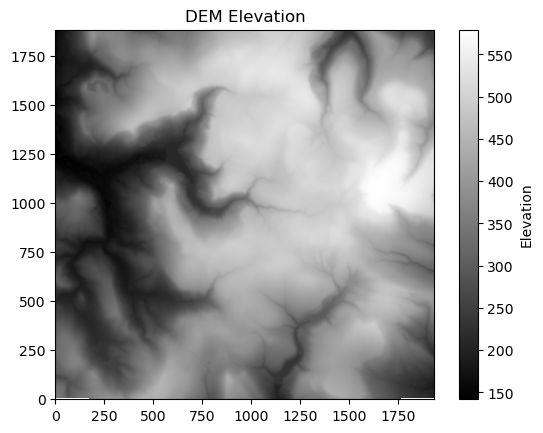

In [111]:
# show the dem world
plt.imshow(dem_array, cmap='gray', origin='lower')
plt.colorbar(label='Elevation')
plt.title('DEM Elevation')
plt.show()
